In [1]:
from tqdm import tqdm

In [2]:
#import modules
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import date, timedelta

import re
import string
import nltk
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from emoji.unicode_codes import UNICODE_EMOJI
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nehel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nehel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nehel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("data\metadata.csv", parse_dates=['publish_time'])

C:\Users\Nehel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.head(2)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [5]:
#The dataset contains a number of missing values
df.isna().sum()

cord_uid                 0
sha                 325801
source_x                 0
title                  232
doi                 216153
pmcid               315384
pubmed_id           255970
license                  0
abstract            134842
publish_time           219
authors              13886
journal              33151
mag_id              497906
who_covidence_id    300338
arxiv_id            491219
pdf_json_files      325801
pmc_json_files      358021
url                 195956
s2_id                49001
dtype: int64

In [6]:
#The dataset contains mostly text/string based data
df.dtypes

cord_uid                    object
sha                         object
source_x                    object
title                       object
doi                         object
pmcid                       object
pubmed_id                   object
license                     object
abstract                    object
publish_time        datetime64[ns]
authors                     object
journal                     object
mag_id                     float64
who_covidence_id            object
arxiv_id                    object
pdf_json_files              object
pmc_json_files              object
url                         object
s2_id                      float64
dtype: object

In [7]:
#Since we want to limit our analysis to the current pandemic, lets see how many articles were published before november 2019
df[df['publish_time'] < pd.Timestamp(2019,11,30)].shape[0]

93883

In [8]:
#There are also some articles which have a publish time in the future, these can be removed as well
df[df['publish_time'] > pd.Timestamp(2021,4,1)].shape[0]

355

In [9]:
#This articles can be removed, furthermore unused columns are also removed below
df = df[df['publish_time'] > pd.Timestamp(2019,11,30)]
df = df[df['publish_time'] < pd.Timestamp(2021,4,1)]
df = df[['title','publish_time','abstract','authors','journal','url']]

In [10]:
#The current dataframe now contains over 403,000 articles
df.shape[0]

403286

In [11]:
#Out of these articles, 120,000 have no text for abstract. Since abstract is to be used to carry out classification, the missing valus are removed
df.isna().sum()

title              221
publish_time         0
abstract        120248
authors           9919
journal          31931
url             194733
dtype: int64

In [12]:
df.dropna(subset=['abstract'],inplace=True)

In [13]:
df.isna().sum()

title               43
publish_time         0
abstract             0
authors           2346
journal          27454
url             128530
dtype: int64

Lets see how the number of published articles changed with time:

In [14]:
df_dates = df.groupby('publish_time').count()['title'].reset_index()

In [15]:
df_dates[df_dates["publish_time"] > pd.Timestamp(2019,12,30)]

,publish_time,title
30,2019-12-31,140
31,2020-01-01,113133
32,2020-01-02,42
33,2020-01-03,42
34,2020-01-04,6
...,...,...
481,2021-03-26,366
482,2021-03-27,15
483,2021-03-29,40
484,2021-03-30,2


In [16]:
df_dates['title'].max()

113133

<AxesSubplot:xlabel='publish_time'>

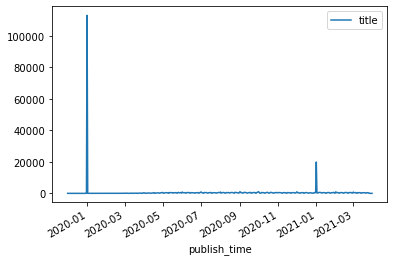

In [17]:
#It is interesting to note that disproportionate amount of new research papers are released on the new years day
df_dates.plot(x="publish_time",y="title")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283038 entries, 4162 to 497905
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         282995 non-null  object        
 1   publish_time  283038 non-null  datetime64[ns]
 2   abstract      283038 non-null  object        
 3   authors       280692 non-null  object        
 4   journal       255584 non-null  object        
 5   url           154508 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 15.1+ MB


In this project a clustering model will be created in order to group similar artices together based on content. In order to group similar artices together, the description from the abstract text of the articles will be used.

Before this is done, cleaning and pre-processing is required on the dataset. 

The following tasks will be perfomed on the dataset for cleaning and pre-processing:

1. Remove all stop words
2. Remove all punctuations
3. Change all text to lower-case
4. Lemmetize test
5. Keep only literature that is in english 

In [19]:
#Create a function to carry out text clearning
stop_words = set(stopwords.words('english'))  

def clean_data(text):
    
    text = str(text)

    #Remove all only numerical data
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)    

    #change all text to lowercase
    text = text.lower()
       
    #delete all hyperlinks and URL's
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #Remove all tags
    text = text.translate(str.maketrans('','','/<[^>]+>/'))
    
    #Remove all punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Remove all stop-words
    text = [w for w in word_tokenize(text) if not w in stop_words]

    return text

In [20]:
#The title might also help in clustering the text, therefore the title and abstract are combined
df['abstract_clean'] = df['title'] + ' ' + df['abstract']

In [21]:
df.reset_index(drop=True,inplace = True)

In [22]:
#Clean Text
df['abstract_clean'] = df['abstract_clean'].apply(lambda x:clean_data(x))

In [23]:
!pip install langdetect

In [24]:
df['abstract_len'] = df['abstract'].apply(lambda x:len(x))

In [25]:
df['abstract_len'] 

0         1430
1          362
2         1075
3         1144
4         1118
          ... 
283033     847
283034     104
283035    1687
283036    1241
283037    1823
Name: abstract_len, Length: 283038, dtype: int64

C:\Users\Nehel\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='abstract_len', ylabel='Density'>

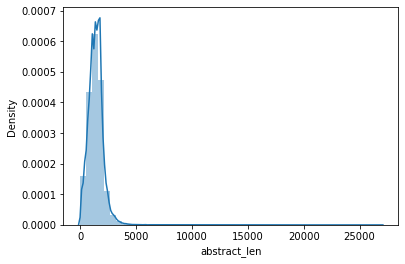

In [26]:
sns.distplot(df['abstract_len'])

In [27]:
from langdetect import detect
from langdetect import DetectorFactory

languages = []
for i in tqdm(range(0,len(df))):
    lang = detect(" ".join(df.iloc[i]['abstract_clean'][0:500]))
    languages.append(lang)

100%|██████████| 283038/283038 [50:08<00:00, 94.07it/s]


In [28]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 283038

{'af': 4,
 'bg': 5,
 'ca': 75,
 'cs': 1,
 'da': 4,
 'de': 360,
 'en': 277122,
 'es': 2272,
 'et': 10,
 'fa': 2,
 'fr': 1056,
 'hr': 2,
 'hu': 33,
 'id': 4,
 'it': 122,
 'ja': 8,
 'ko': 24,
 'lt': 1,
 'mk': 1,
 'nl': 166,
 'no': 13,
 'pl': 1,
 'pt': 1129,
 'ro': 32,
 'ru': 325,
 'sl': 1,
 'sv': 1,
 'tl': 44,
 'tr': 38,
 'uk': 1,
 'vi': 19,
 'zh-cn': 161,
 'zh-tw': 1}


While the majority of the artices are in english, french and portugeese are also common languages. For simplicity, these languages are removed and only english text is considered. 

In [39]:
df['languages'] = languages
df =df[df['languages'] == 'en'] 
df.shape

(277122, 9)

We can now proceed to vectorizing the data and training a K-means model. Since the model will be trained on the vectorized text data, the model will have features equal to the overall vocabulary of the corpus. Due to this big vocabulary, it is best to conduct PCA to limit the number of features. We will be only keeping features that explain 95% of the variance of the dataset.

## Vectorize Data

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['abstract_clean'].apply(lambda x: ' '.join(x)))

## Conduct PCA
